# Experiment 6: Pose MLP - Enhanced Feature Engineering

Robust comparison of pose-based models using **30-run aggregated statistics** with config-based training.

## Configurations

| Config | Features | Description |
|--------|----------|-------------|
| **A** (Baseline) | 19 | 13 joint angles + 6 distances |
| **B** (Specialized) | 37 | Base + 18 specialized discrimination features |

**Key Features:**
- Enhanced pose features with specialized discrimination for confusion clusters
- Temporal sequences (50 timesteps × N features)
- Subject-wise stratified train/val/test splits (no subject leakage)
- 30 runs per configuration with different random seeds
- Comprehensive statistical analysis and visualization

In [1]:
from pathlib import Path
import sys
import numpy as np

PROJECT_ROOT = Path('..').resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Force reload modules to pick up latest changes
import importlib
import src.data.data_loader
import src.data.dataset_builder
import src.scripts.experiment_6
importlib.reload(src.data.data_loader)
importlib.reload(src.data.dataset_builder)
importlib.reload(src.scripts.experiment_6)

from src.data.data_loader import load_pose_enhanced_data
from src.scripts.experiment_6 import train_experiment_6_multi_run


print("✅ Modules loaded successfully")

✅ Modules loaded successfully


In [2]:
importlib.reload(src.utils.visualization)

from src.utils.visualization import (
    plot_confusion_matrix_from_metrics,
    plot_per_class_f1_scores,
    sort_labels_by_numeric_prefix,
    display_multi_run_summary,
    plot_multi_run_distributions,
    plot_best_worst_comparison,
    plot_aggregated_confusion_matrix,
    plot_dual_training_history,
    compare_multi_run_stats,
)
import matplotlib.pyplot as plt
import pandas as pd

print("✅ Visualization functions loaded")

✅ Visualization functions loaded


---

## Configuration Selection

Select which configuration to run. Available options:

- **`A`** - Baseline: 19 features (13 angles + 6 distances)
- **`B`** - Base + Specialized: 37 features (19 + 18 specialized discrimination features)

In [3]:
# ============================================================
# 🔧 CONFIGURATION SELECTION - MODIFY THIS CELL
# ============================================================

# Select configuration: 'A' or 'B'
SELECTED_CONFIG = 'B'

# Select view: 'front' or 'side'
SELECTED_VIEW = 'side'

# ============================================================
# Configuration mappings (DO NOT MODIFY)
# ============================================================

CONFIG_MAP = {
    'A': {
        'name': 'Baseline',
        'feature_type_front': 'all',
        'feature_type_side': 'all',
        'num_features': 19,
        'config_front': 'experiment_6_temporal_front.yaml',
        'config_side': 'experiment_6_temporal_side.yaml',
        'description': '13 joint angles + 6 distances'
    },
    'B': {
        'name': 'Base + Specialized',
        'feature_type_front': 'front_all_extended',
        'feature_type_side': 'side_all_extended',
        'num_features': 37,
        'config_front': 'experiment_6_ablation_specialized_front.yaml',
        'config_side': 'experiment_6_ablation_specialized_side.yaml',
        'description': '19 base + 18 specialized discrimination features'
    }
}

# Get selected configuration
config_info = CONFIG_MAP[SELECTED_CONFIG]
config_file = config_info[f'config_{SELECTED_VIEW}']
feature_type = config_info[f'feature_type_{SELECTED_VIEW}']

print("=" * 60)
print(f"📋 SELECTED CONFIGURATION: {SELECTED_CONFIG} - {config_info['name']}")
print("=" * 60)
print(f"  View: {SELECTED_VIEW.upper()}")
print(f"  Feature type: {feature_type}")
print(f"  Number of features: {config_info['num_features']}")
print(f"  Description: {config_info['description']}")
print(f"  Config file: {config_file}")
print("=" * 60)

📋 SELECTED CONFIGURATION: B - Base + Specialized
  View: SIDE
  Feature type: side_all_extended
  Number of features: 37
  Description: 19 base + 18 specialized discrimination features
  Config file: experiment_6_ablation_specialized_side.yaml


---

## Data Loading

Load and summarize the enhanced pose feature dataset for the selected view.

In [4]:
# Define paths to enhanced pose NPZ files
npz_paths = {
    'front': PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_front_19_features.npz',
    'side': PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_side_19_features.npz'
}

# Load data for selected view
npz_path = npz_paths[SELECTED_VIEW]

dataset, summary = load_pose_enhanced_data(str(npz_path), feature_type=feature_type)

print(f"\n📊 {SELECTED_VIEW.upper()} VIEW - {config_info['name']} Features:")
print(f"  Samples: {summary['count']}")
print(f"  Subjects: {summary['unique_subjects']}")
print(f"  Classes: {summary['unique_classes']}")
print(f"  Temporal shape: {summary['temporal_shape']} (timesteps × features)")
print(f"  Flattened to: {summary['temporal_shape'][0] * summary['temporal_shape'][1]} features per sample")
print(f"\n  Feature names ({len(summary['feature_names'])}):")
for i, name in enumerate(summary['feature_names'][:10]):
    print(f"    {i+1}. {name}")
if len(summary['feature_names']) > 10:
    print(f"    ... and {len(summary['feature_names']) - 10} more")

INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)



📊 SIDE VIEW - Base + Specialized Features:
  Samples: 1571
  Subjects: 49
  Classes: 15
  Temporal shape: (50, 37) (timesteps × features)
  Flattened to: 1850 features per sample

  Feature names (37):
    1. left_elbow
    2. right_elbow
    3. left_shoulder
    4. right_shoulder
    5. left_hip
    6. right_hip
    7. left_knee
    8. right_knee
    9. torso_lean
    10. left_ankle
    ... and 27 more


---

## Multi-Run Training (30 Runs)

Execute 30 training runs with different random seeds using the selected configuration.

In [5]:
# Train model with multi-run (30 runs)
print("=" * 80)
print(f"MULTI-RUN TRAINING: CONFIG {SELECTED_CONFIG} ({config_info['name']}) - {SELECTED_VIEW.upper()} VIEW")
print("=" * 80)

config_path = PROJECT_ROOT / 'config' / config_file

multi_run_results, aggregated_stats = train_experiment_6_multi_run(
    npz_path=str(npz_path),
    config_path=str(config_path)
)

print(f"\n✅ Config {SELECTED_CONFIG} ({SELECTED_VIEW} view) multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats['test_accuracy']['mean']:.4f} ± {aggregated_stats['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats['test_macro_f1']['mean']:.4f} ± {aggregated_stats['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003


INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43


MULTI-RUN TRAINING: CONFIG B (Base + Specialized) - SIDE VIEW


INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=864, val=253, test=454, classes=15
I0000 00:00:1769550840.598269   72306 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
INFO - Datasets built with feature_dim=1850


Epoch 1/220
23/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0829 - loss: 3.3943 

I0000 00:00:1769550848.790363   72427 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.1447 - loss: 2.9869 - val_accuracy: 0.4664 - val_loss: 1.8509 - learning_rate: 5.0000e-05
Epoch 2/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3194 - loss: 2.0773 - val_accuracy: 0.7154 - val_loss: 1.4598 - learning_rate: 5.0000e-05
Epoch 3/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4734 - loss: 1.5948 - val_accuracy: 0.7826 - val_loss: 1.1903 - learning_rate: 5.0000e-05
Epoch 4/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5799 - loss: 1.3383 - val_accuracy: 0.7905 - val_loss: 1.0152 - learning_rate: 5.0000e-05
Epoch 5/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6551 - loss: 1.0967 - val_accuracy: 0.8340 - val_loss: 0.8972 - learning_rate: 5.0000e-05
Epoch 6/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7303 - loss: 0.9046 - val_accuracy: 0.8617 - val_loss: 0.7873 - learning_rate: 5.0000e-05
Epoch 7/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7558 - loss: 0.

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_001/model.keras
INFO - Run 1 complete: acc=0.9097, macro_f1=0.9074
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=903, val=247, test=421, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.1362 - loss: 3.0566 - val_accuracy: 0.5830 - val_loss: 1.8083 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3511 - loss: 2.0572 - val_accuracy: 0.6802 - val_loss: 1.3289 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4817 - loss: 1.6205 - val_accuracy: 0.7287 - val_loss: 1.0814 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6024 - loss: 1.2912 - val_accuracy: 0.8097 - val_loss: 0.8821 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6711 - loss: 1.0617 - val_accuracy: 0.8462 - val_loss: 0.7426 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7143 - loss: 0.9390 - val_accuracy: 0.8664 - val_loss: 0.6436 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7719

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_002/model.keras
INFO - Run 2 complete: acc=0.9311, macro_f1=0.9265
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=914, val=232, test=425, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.1400 - loss: 2.9498 - val_accuracy: 0.5819 - val_loss: 1.7684 - learning_rate: 5.0000e-05
Epoch 2/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3260 - loss: 2.0230 - val_accuracy: 0.6595 - val_loss: 1.3947 - learning_rate: 5.0000e-05
Epoch 3/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5022 - loss: 1.5829 - val_accuracy: 0.6897 - val_loss: 1.1345 - learning_rate: 5.0000e-05
Epoch 4/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 1.2955 - val_accuracy: 0.7026 - val_loss: 0.9616 - learning_rate: 5.0000e-05
Epoch 5/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6707 - loss: 1.0543 - val_accuracy: 0.7802 - val_loss: 0.8106 - learning_rate: 5.0000e-05
Epoch 6/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7385 - loss: 0.8551 - val_accuracy: 0.8190 - val_loss: 0.7101 - learning_rate: 5.0000e-05
Epoch 7/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.782

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_003/model.keras
INFO - Run 3 complete: acc=0.8894, macro_f1=0.8831
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=883, val=210, test=478, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.1416 - loss: 3.0362 - val_accuracy: 0.3000 - val_loss: 2.2327 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3035 - loss: 2.2301 - val_accuracy: 0.5381 - val_loss: 1.8061 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4609 - loss: 1.7393 - val_accuracy: 0.6333 - val_loss: 1.4592 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5447 - loss: 1.4457 - val_accuracy: 0.7095 - val_loss: 1.2184 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6580 - loss: 1.1437 - val_accuracy: 0.8095 - val_loss: 0.9953 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6750 - loss: 1.0348 - val_accuracy: 0.8143 - val_loss: 0.8476 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7633

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_004/model.keras
INFO - Run 4 complete: acc=0.9435, macro_f1=0.9407
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=932, val=220, test=419, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.1620 - loss: 2.9745 - val_accuracy: 0.4818 - val_loss: 1.9773 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3090 - loss: 2.1187 - val_accuracy: 0.5955 - val_loss: 1.5991 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5215 - loss: 1.5359 - val_accuracy: 0.6727 - val_loss: 1.2917 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6202 - loss: 1.2402 - val_accuracy: 0.7000 - val_loss: 1.1117 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6942 - loss: 0.9886 - val_accuracy: 0.7182 - val_loss: 0.9755 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7758 - loss: 0.7933 - val_accuracy: 0.7364 - val_loss: 0.9058 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.799

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_005/model.keras
INFO - Run 5 complete: acc=0.9236, macro_f1=0.9212
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=903, val=253, test=415, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1606 - loss: 2.9557 - val_accuracy: 0.5455 - val_loss: 1.8451 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3810 - loss: 1.9304 - val_accuracy: 0.7154 - val_loss: 1.3820 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5227 - loss: 1.4854 - val_accuracy: 0.8024 - val_loss: 1.0950 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6412 - loss: 1.1553 - val_accuracy: 0.8538 - val_loss: 0.9284 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6988 - loss: 0.9288 - val_accuracy: 0.8617 - val_loss: 0.8222 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7818 - loss: 0.7387 - val_accuracy: 0.8854 - val_loss: 0.7189 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7984

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_006/model.keras
INFO - Run 6 complete: acc=0.8892, macro_f1=0.8862
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=943, val=175, test=453, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.1251 - loss: 3.1913 - val_accuracy: 0.4743 - val_loss: 1.8478 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3171 - loss: 2.1325 - val_accuracy: 0.6857 - val_loss: 1.3090 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4666 - loss: 1.7011 - val_accuracy: 0.7771 - val_loss: 1.0181 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 1.3557 - val_accuracy: 0.8400 - val_loss: 0.8050 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6554 - loss: 1.1045 - val_accuracy: 0.9200 - val_loss: 0.6486 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7211 - loss: 0.9221 - val_accuracy: 0.9371 - val_loss: 0.5236 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7497

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_007/model.keras
INFO - Run 7 complete: acc=0.9360, macro_f1=0.9422
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=984, val=226, test=361, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.1301 - loss: 3.0044 - val_accuracy: 0.3540 - val_loss: 2.2026 - learning_rate: 5.0000e-05
Epoch 2/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3313 - loss: 2.0489 - val_accuracy: 0.3982 - val_loss: 1.8350 - learning_rate: 5.0000e-05
Epoch 3/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5122 - loss: 1.5381 - val_accuracy: 0.5044 - val_loss: 1.5716 - learning_rate: 5.0000e-05
Epoch 4/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6413 - loss: 1.1461 - val_accuracy: 0.6150 - val_loss: 1.3191 - learning_rate: 5.0000e-05
Epoch 5/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6961 - loss: 0.9734 - val_accuracy: 0.6593 - val_loss: 1.1776 - learning_rate: 5.0000e-05
Epoch 6/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7642 - loss: 0.8000 - val_accuracy: 0.6549 - val_loss: 1.1448 - learning_rate: 5.0000e-05
Epoch 7/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8191

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_008/model.keras
INFO - Run 8 complete: acc=0.9197, macro_f1=0.9169
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=873, val=250, test=448, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.1271 - loss: 3.1696 - val_accuracy: 0.4760 - val_loss: 2.0585 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2852 - loss: 2.2022 - val_accuracy: 0.6920 - val_loss: 1.5236 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4536 - loss: 1.6929 - val_accuracy: 0.6960 - val_loss: 1.2182 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5785 - loss: 1.3156 - val_accuracy: 0.7600 - val_loss: 1.0125 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6747 - loss: 1.0504 - val_accuracy: 0.7480 - val_loss: 0.8963 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.9139 - val_accuracy: 0.7840 - val_loss: 0.7884 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7732

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_009/model.keras
INFO - Run 9 complete: acc=0.8661, macro_f1=0.8697
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=899, val=259, test=413, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.1046 - loss: 2.9990 - val_accuracy: 0.3398 - val_loss: 2.1674 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3259 - loss: 2.0616 - val_accuracy: 0.4710 - val_loss: 1.8606 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4672 - loss: 1.6517 - val_accuracy: 0.5830 - val_loss: 1.6532 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 1.2895 - val_accuracy: 0.5714 - val_loss: 1.5347 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 1.0304 - val_accuracy: 0.5830 - val_loss: 1.4657 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7875 - loss: 0.8169 - val_accuracy: 0.6486 - val_loss: 1.3492 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7686

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_010/model.keras
INFO - Run 10 complete: acc=0.8692, macro_f1=0.8719
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=846, val=289, test=436, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.1324 - loss: 3.1086 - val_accuracy: 0.3910 - val_loss: 2.0422 - learning_rate: 5.0000e-05
Epoch 2/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3121 - loss: 2.2331 - val_accuracy: 0.5571 - val_loss: 1.5928 - learning_rate: 5.0000e-05
Epoch 3/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4243 - loss: 1.8300 - val_accuracy: 0.6990 - val_loss: 1.2800 - learning_rate: 5.0000e-05
Epoch 4/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5485 - loss: 1.4590 - val_accuracy: 0.8062 - val_loss: 0.9988 - learning_rate: 5.0000e-05
Epoch 5/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5969 - loss: 1.2222 - val_accuracy: 0.8616 - val_loss: 0.7788 - learning_rate: 5.0000e-05
Epoch 6/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7139 - loss: 0.9753 - val_accuracy: 0.9135 - val_loss: 0.5956 - learning_rate: 5.0000e-05
Epoch 7/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7530

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_011/model.keras
INFO - Run 11 complete: acc=0.8968, macro_f1=0.8933
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=927, val=221, test=423, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1294 - loss: 3.1326 - val_accuracy: 0.4434 - val_loss: 2.0858 - learning_rate: 5.0000e-05
Epoch 2/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3355 - loss: 2.1402 - val_accuracy: 0.6018 - val_loss: 1.6401 - learning_rate: 5.0000e-05
Epoch 3/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4595 - loss: 1.7494 - val_accuracy: 0.7240 - val_loss: 1.3184 - learning_rate: 5.0000e-05
Epoch 4/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5890 - loss: 1.3575 - val_accuracy: 0.7964 - val_loss: 1.0941 - learning_rate: 5.0000e-05
Epoch 5/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6753 - loss: 1.1063 - val_accuracy: 0.8281 - val_loss: 0.9036 - learning_rate: 5.0000e-05
Epoch 6/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7368 - loss: 0.8785 - val_accuracy: 0.8326 - val_loss: 0.7959 - learning_rate: 5.0000e-05
Epoch 7/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7972

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_012/model.keras
INFO - Run 12 complete: acc=0.9598, macro_f1=0.9572
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=880, val=215, test=476, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1307 - loss: 3.0725 - val_accuracy: 0.5442 - val_loss: 1.9546 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2739 - loss: 2.2508 - val_accuracy: 0.7395 - val_loss: 1.4141 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4455 - loss: 1.6991 - val_accuracy: 0.8372 - val_loss: 1.0313 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5864 - loss: 1.3374 - val_accuracy: 0.8930 - val_loss: 0.8069 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6807 - loss: 1.0557 - val_accuracy: 0.9488 - val_loss: 0.6261 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6852 - loss: 0.9453 - val_accuracy: 0.9535 - val_loss: 0.5088 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7807

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_013/model.keras
INFO - Run 13 complete: acc=0.9013, macro_f1=0.9100
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=828, val=258, test=485, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.1304 - loss: 3.1443 - val_accuracy: 0.2752 - val_loss: 2.2384 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2681 - loss: 2.2641 - val_accuracy: 0.5000 - val_loss: 1.8087 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4275 - loss: 1.8217 - val_accuracy: 0.7171 - val_loss: 1.5317 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5519 - loss: 1.4677 - val_accuracy: 0.7481 - val_loss: 1.3250 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6389 - loss: 1.1948 - val_accuracy: 0.7713 - val_loss: 1.1505 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7077 - loss: 0.9845 - val_accuracy: 0.7597 - val_loss: 1.0312 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7415

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_014/model.keras
INFO - Run 14 complete: acc=0.8907, macro_f1=0.8890
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=821, val=261, test=489, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.1352 - loss: 3.0440 - val_accuracy: 0.6130 - val_loss: 1.8641 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3094 - loss: 2.2038 - val_accuracy: 0.8123 - val_loss: 1.3185 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4531 - loss: 1.7009 - val_accuracy: 0.8238 - val_loss: 0.9855 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5871 - loss: 1.3400 - val_accuracy: 0.8697 - val_loss: 0.7509 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6590 - loss: 1.1140 - val_accuracy: 0.8506 - val_loss: 0.6103 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7259 - loss: 0.9148 - val_accuracy: 0.8774 - val_loss: 0.5198 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.790

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_015/model.keras
INFO - Run 15 complete: acc=0.8998, macro_f1=0.9072
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=902, val=212, test=457, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.1685 - loss: 2.8099 - val_accuracy: 0.5377 - val_loss: 1.9035 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3537 - loss: 1.9792 - val_accuracy: 0.7642 - val_loss: 1.3751 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5288 - loss: 1.5024 - val_accuracy: 0.8066 - val_loss: 1.0330 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6364 - loss: 1.2096 - val_accuracy: 0.8349 - val_loss: 0.8065 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6729 - loss: 1.0385 - val_accuracy: 0.8679 - val_loss: 0.6445 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7761 - loss: 0.7935 - val_accuracy: 0.8774 - val_loss: 0.5254 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_016/model.keras
INFO - Run 16 complete: acc=0.8403, macro_f1=0.8462
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=906, val=258, test=407, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.1236 - loss: 2.9913 - val_accuracy: 0.5233 - val_loss: 1.9575 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3146 - loss: 2.1617 - val_accuracy: 0.6628 - val_loss: 1.4916 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4823 - loss: 1.6426 - val_accuracy: 0.7364 - val_loss: 1.1978 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5982 - loss: 1.3547 - val_accuracy: 0.7713 - val_loss: 0.9881 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6909 - loss: 1.0944 - val_accuracy: 0.8062 - val_loss: 0.8292 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7042 - loss: 0.9846 - val_accuracy: 0.8140 - val_loss: 0.7351 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7704

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_017/model.keras
INFO - Run 17 complete: acc=0.8870, macro_f1=0.8714
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=984, val=187, test=400, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1321 - loss: 3.0169 - val_accuracy: 0.4492 - val_loss: 1.9944 - learning_rate: 5.0000e-05
Epoch 2/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3354 - loss: 2.0332 - val_accuracy: 0.6738 - val_loss: 1.5117 - learning_rate: 5.0000e-05
Epoch 3/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 1.5016 - val_accuracy: 0.7059 - val_loss: 1.2012 - learning_rate: 5.0000e-05
Epoch 4/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6463 - loss: 1.2105 - val_accuracy: 0.7594 - val_loss: 0.9712 - learning_rate: 5.0000e-05
Epoch 5/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6809 - loss: 1.0433 - val_accuracy: 0.8021 - val_loss: 0.8305 - learning_rate: 5.0000e-05
Epoch 6/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.8320 - val_accuracy: 0.8128 - val_loss: 0.7195 - learning_rate: 5.0000e-05
Epoch 7/220
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7927

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_018/model.keras
INFO - Run 18 complete: acc=0.8825, macro_f1=0.8584
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=849, val=280, test=442, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1625 - loss: 2.8651 - val_accuracy: 0.3429 - val_loss: 2.0552 - learning_rate: 5.0000e-05
Epoch 2/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3404 - loss: 2.0369 - val_accuracy: 0.5643 - val_loss: 1.6996 - learning_rate: 5.0000e-05
Epoch 3/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 1.5019 - val_accuracy: 0.6214 - val_loss: 1.4763 - learning_rate: 5.0000e-05
Epoch 4/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5807 - loss: 1.3029 - val_accuracy: 0.6393 - val_loss: 1.3347 - learning_rate: 5.0000e-05
Epoch 5/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6749 - loss: 1.0542 - val_accuracy: 0.6857 - val_loss: 1.1887 - learning_rate: 5.0000e-05
Epoch 6/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7303 - loss: 0.8820 - val_accuracy: 0.7071 - val_loss: 1.1217 - learning_rate: 5.0000e-05
Epoch 7/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7668

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_019/model.keras
INFO - Run 19 complete: acc=0.9457, macro_f1=0.9405
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=877, val=245, test=449, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.1574 - loss: 3.0351 - val_accuracy: 0.4653 - val_loss: 1.9704 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3216 - loss: 2.1463 - val_accuracy: 0.6939 - val_loss: 1.5502 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4766 - loss: 1.6384 - val_accuracy: 0.8286 - val_loss: 1.2298 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5747 - loss: 1.3631 - val_accuracy: 0.8735 - val_loss: 0.9931 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6477 - loss: 1.1170 - val_accuracy: 0.9102 - val_loss: 0.7970 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7434 - loss: 0.8849 - val_accuracy: 0.9184 - val_loss: 0.6641 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_020/model.keras
INFO - Run 20 complete: acc=0.9310, macro_f1=0.9235
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=825, val=245, test=501, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.1491 - loss: 2.9104 - val_accuracy: 0.3918 - val_loss: 1.9606 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3345 - loss: 2.0853 - val_accuracy: 0.5592 - val_loss: 1.5412 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5042 - loss: 1.5857 - val_accuracy: 0.6898 - val_loss: 1.2261 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6012 - loss: 1.2630 - val_accuracy: 0.7714 - val_loss: 0.9878 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6776 - loss: 1.0342 - val_accuracy: 0.8082 - val_loss: 0.8351 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7358 - loss: 0.9012 - val_accuracy: 0.8245 - val_loss: 0.7031 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7964

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_021/model.keras
INFO - Run 21 complete: acc=0.8743, macro_f1=0.8775
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=894, val=275, test=402, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.1432 - loss: 3.1087 - val_accuracy: 0.5164 - val_loss: 2.0057 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3412 - loss: 2.1376 - val_accuracy: 0.7309 - val_loss: 1.5504 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5168 - loss: 1.6080 - val_accuracy: 0.7636 - val_loss: 1.2271 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6186 - loss: 1.2388 - val_accuracy: 0.7891 - val_loss: 0.9834 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6935 - loss: 1.0287 - val_accuracy: 0.8109 - val_loss: 0.8341 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7405 - loss: 0.8429 - val_accuracy: 0.8291 - val_loss: 0.7201 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7752

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_022/model.keras
INFO - Run 22 complete: acc=0.8657, macro_f1=0.8632
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=920, val=202, test=449, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1576 - loss: 2.9490 - val_accuracy: 0.5347 - val_loss: 1.8436 - learning_rate: 5.0000e-05
Epoch 2/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3196 - loss: 2.1643 - val_accuracy: 0.6634 - val_loss: 1.3969 - learning_rate: 5.0000e-05
Epoch 3/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4435 - loss: 1.7118 - val_accuracy: 0.7871 - val_loss: 1.1214 - learning_rate: 5.0000e-05
Epoch 4/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5913 - loss: 1.3599 - val_accuracy: 0.8812 - val_loss: 0.8992 - learning_rate: 5.0000e-05
Epoch 5/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6587 - loss: 1.1294 - val_accuracy: 0.9010 - val_loss: 0.7284 - learning_rate: 5.0000e-05
Epoch 6/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6957 - loss: 0.9381 - val_accuracy: 0.9307 - val_loss: 0.6087 - learning_rate: 5.0000e-05
Epoch 7/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_023/model.keras
INFO - Run 23 complete: acc=0.8953, macro_f1=0.9022
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=883, val=264, test=424, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1699 - loss: 2.8489 - val_accuracy: 0.5417 - val_loss: 1.8112 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3511 - loss: 1.9521 - val_accuracy: 0.6856 - val_loss: 1.3640 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5323 - loss: 1.4459 - val_accuracy: 0.7121 - val_loss: 1.0873 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6501 - loss: 1.1270 - val_accuracy: 0.7462 - val_loss: 0.9247 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7384 - loss: 0.9231 - val_accuracy: 0.7689 - val_loss: 0.8470 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7916 - loss: 0.7191 - val_accuracy: 0.7917 - val_loss: 0.7945 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_024/model.keras
INFO - Run 24 complete: acc=0.8608, macro_f1=0.8691
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=933, val=189, test=449, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1404 - loss: 3.1687 - val_accuracy: 0.5450 - val_loss: 1.8071 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2980 - loss: 2.1806 - val_accuracy: 0.8889 - val_loss: 1.2528 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4887 - loss: 1.6562 - val_accuracy: 0.9524 - val_loss: 0.8752 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5916 - loss: 1.2945 - val_accuracy: 0.9365 - val_loss: 0.6378 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6549 - loss: 1.0924 - val_accuracy: 0.9788 - val_loss: 0.4735 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7224 - loss: 0.8887 - val_accuracy: 0.9947 - val_loss: 0.3666 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7578

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_025/model.keras
INFO - Run 25 complete: acc=0.9087, macro_f1=0.9049
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=857, val=246, test=468, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1517 - loss: 2.8328 - val_accuracy: 0.5203 - val_loss: 1.9964 - learning_rate: 5.0000e-05
Epoch 2/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3116 - loss: 2.1653 - val_accuracy: 0.6829 - val_loss: 1.5158 - learning_rate: 5.0000e-05
Epoch 3/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5018 - loss: 1.6178 - val_accuracy: 0.7967 - val_loss: 1.1738 - learning_rate: 5.0000e-05
Epoch 4/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5659 - loss: 1.3608 - val_accuracy: 0.8415 - val_loss: 0.9424 - learning_rate: 5.0000e-05
Epoch 5/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6744 - loss: 1.1054 - val_accuracy: 0.8577 - val_loss: 0.7607 - learning_rate: 5.0000e-05
Epoch 6/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7363 - loss: 0.9094 - val_accuracy: 0.8618 - val_loss: 0.6541 - learning_rate: 5.0000e-05
Epoch 7/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8086

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_026/model.keras
INFO - Run 26 complete: acc=0.8996, macro_f1=0.9017
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=871, val=263, test=437, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1378 - loss: 2.9304 - val_accuracy: 0.4867 - val_loss: 1.9885 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3364 - loss: 2.0626 - val_accuracy: 0.6958 - val_loss: 1.5806 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4386 - loss: 1.6816 - val_accuracy: 0.7529 - val_loss: 1.3190 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5844 - loss: 1.3460 - val_accuracy: 0.7833 - val_loss: 1.1021 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6636 - loss: 1.1216 - val_accuracy: 0.8061 - val_loss: 0.9317 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7141 - loss: 0.9584 - val_accuracy: 0.8441 - val_loss: 0.8115 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7566

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_027/model.keras
INFO - Run 27 complete: acc=0.9451, macro_f1=0.9480
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=835, val=262, test=474, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1341 - loss: 3.0140 - val_accuracy: 0.3931 - val_loss: 2.0278 - learning_rate: 5.0000e-05
Epoch 2/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3174 - loss: 2.1436 - val_accuracy: 0.6031 - val_loss: 1.6778 - learning_rate: 5.0000e-05
Epoch 3/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4647 - loss: 1.6465 - val_accuracy: 0.6756 - val_loss: 1.4328 - learning_rate: 5.0000e-05
Epoch 4/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5737 - loss: 1.3263 - val_accuracy: 0.7672 - val_loss: 1.2168 - learning_rate: 5.0000e-05
Epoch 5/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6443 - loss: 1.1317 - val_accuracy: 0.7863 - val_loss: 1.0687 - learning_rate: 5.0000e-05
Epoch 6/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 0.9029 - val_accuracy: 0.8359 - val_loss: 0.9329 - learning_rate: 5.0000e-05
Epoch 7/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7784

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_028/model.keras
INFO - Run 28 complete: acc=0.9262, macro_f1=0.9276
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=964, val=227, test=380, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1535 - loss: 2.9624 - val_accuracy: 0.4934 - val_loss: 1.8887 - learning_rate: 5.0000e-05
Epoch 2/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3496 - loss: 2.0366 - val_accuracy: 0.6520 - val_loss: 1.4014 - learning_rate: 5.0000e-05
Epoch 3/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5031 - loss: 1.5740 - val_accuracy: 0.7709 - val_loss: 1.0715 - learning_rate: 5.0000e-05
Epoch 4/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6183 - loss: 1.2047 - val_accuracy: 0.7930 - val_loss: 0.8630 - learning_rate: 5.0000e-05
Epoch 5/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6888 - loss: 1.0100 - val_accuracy: 0.8062 - val_loss: 0.7353 - learning_rate: 5.0000e-05
Epoch 6/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7604 - loss: 0.7779 - val_accuracy: 0.7974 - val_loss: 0.6776 - learning_rate: 5.0000e-05
Epoch 7/220
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7988

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_029/model.keras
INFO - Run 29 complete: acc=0.9211, macro_f1=0.9092
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_enhanced_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, feature_type=side_all_extended, shape=(50, 37)
INFO - Loaded side_all_extended features: 1571 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=834, val=243, test=494, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.1091 - loss: 3.2603 - val_accuracy: 0.4074 - val_loss: 2.1596 - learning_rate: 5.0000e-05
Epoch 2/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2770 - loss: 2.2522 - val_accuracy: 0.6996 - val_loss: 1.5959 - learning_rate: 5.0000e-05
Epoch 3/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4281 - loss: 1.7836 - val_accuracy: 0.7654 - val_loss: 1.2231 - learning_rate: 5.0000e-05
Epoch 4/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5528 - loss: 1.4199 - val_accuracy: 0.8066 - val_loss: 0.9672 - learning_rate: 5.0000e-05
Epoch 5/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6211 - loss: 1.2012 - val_accuracy: 0.8395 - val_loss: 0.7871 - learning_rate: 5.0000e-05
Epoch 6/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7014 - loss: 0.9800 - val_accuracy: 0.8889 - val_loss: 0.6543 - learning_rate: 5.0000e-05
Epoch 7/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7470

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/side/multi_run_003/run_030/model.keras
INFO - Run 30 complete: acc=0.9393, macro_f1=0.9410
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.9049 ± 0.0293
INFO - Test Macro F1: 0.9036 ± 0.0292
INFO - ================================================================================



✅ Config B (side view) multi-run training complete!
Mean Test Accuracy: 0.9049 ± 0.0293
Mean Test Macro F1: 0.9036 ± 0.0292


---

## Multi-Run Analysis

Detailed analysis of 30 runs for the selected configuration.

In [6]:
# Display summary table for runs
print("=" * 80)
print(f"CONFIG {SELECTED_CONFIG} ({config_info['name']}) - {SELECTED_VIEW.upper()} VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df = display_multi_run_summary(multi_run_results, aggregated_stats)

CONFIG B (Base + Specialized) - SIDE VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.9049 ± 0.0293
  Min: 0.8403
  Max: 0.9598

Test Macro F1:  0.9036 ± 0.0292
  Min: 0.8462
  Max: 0.9572


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min  max
Class                             
0      0.9641  0.0471  0.8095  1.0
1      0.8382  0.1182  0.5833  1.0
2      0.9690  0.0427  0.8163  1.0
3      0.8917  0.0951  0.6984  1.0
4      0.8571  0.1267  0.4615  1.0
5      0.8568  0.1109  0.4359  1.0
6      0.9195  0.0783  0.7467  1.0
7      0.8203  0.1361  0.4828  1.0
8      0.9195  0.0732  0.7500  1.0
9      0.9509  0.0598  0.7797  1.0
10     0.9580  0.0745  0.7451  1.0
11     0.7854  0.1526  0.4444  1.0
12     0.9287  0.0906  0.6585  1.0
13     0.9432  0.0652  0.7436  1.0
14     0.9512  0.0624  0.7925  1.0


### Distribution Plots

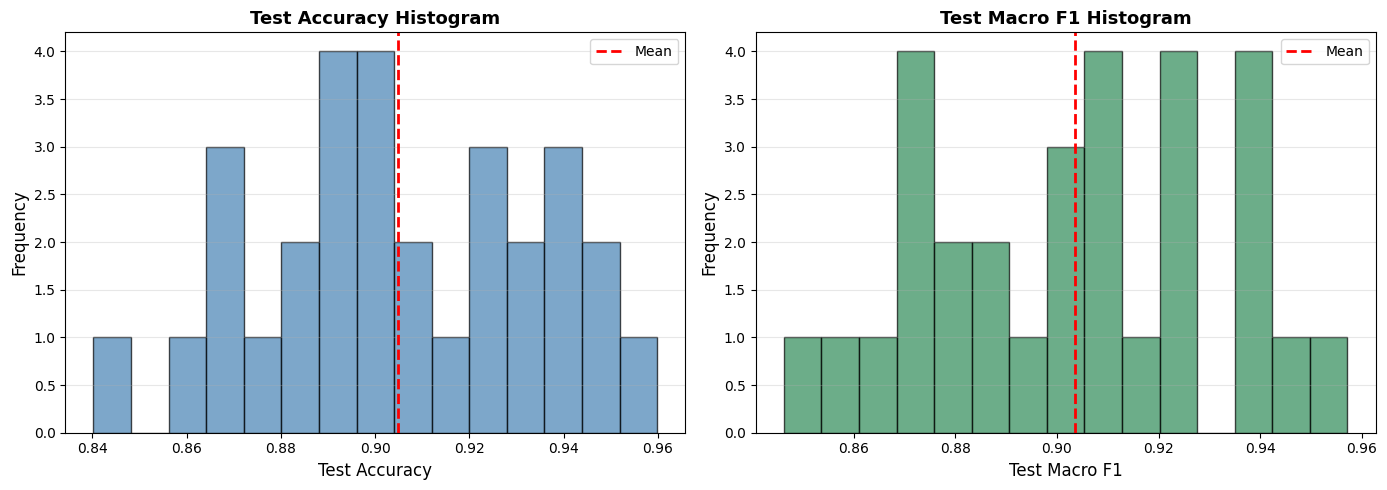

In [7]:
# Plot distributions for runs
plot_multi_run_distributions(multi_run_results, aggregated_stats)


CONFIG B: BEST vs WORST RUN COMPARISON
Best Run:  #12 (seed=54) - Acc: 0.9598, F1: 0.9572
Worst Run: #16 (seed=58) - Acc: 0.8403, F1: 0.8462


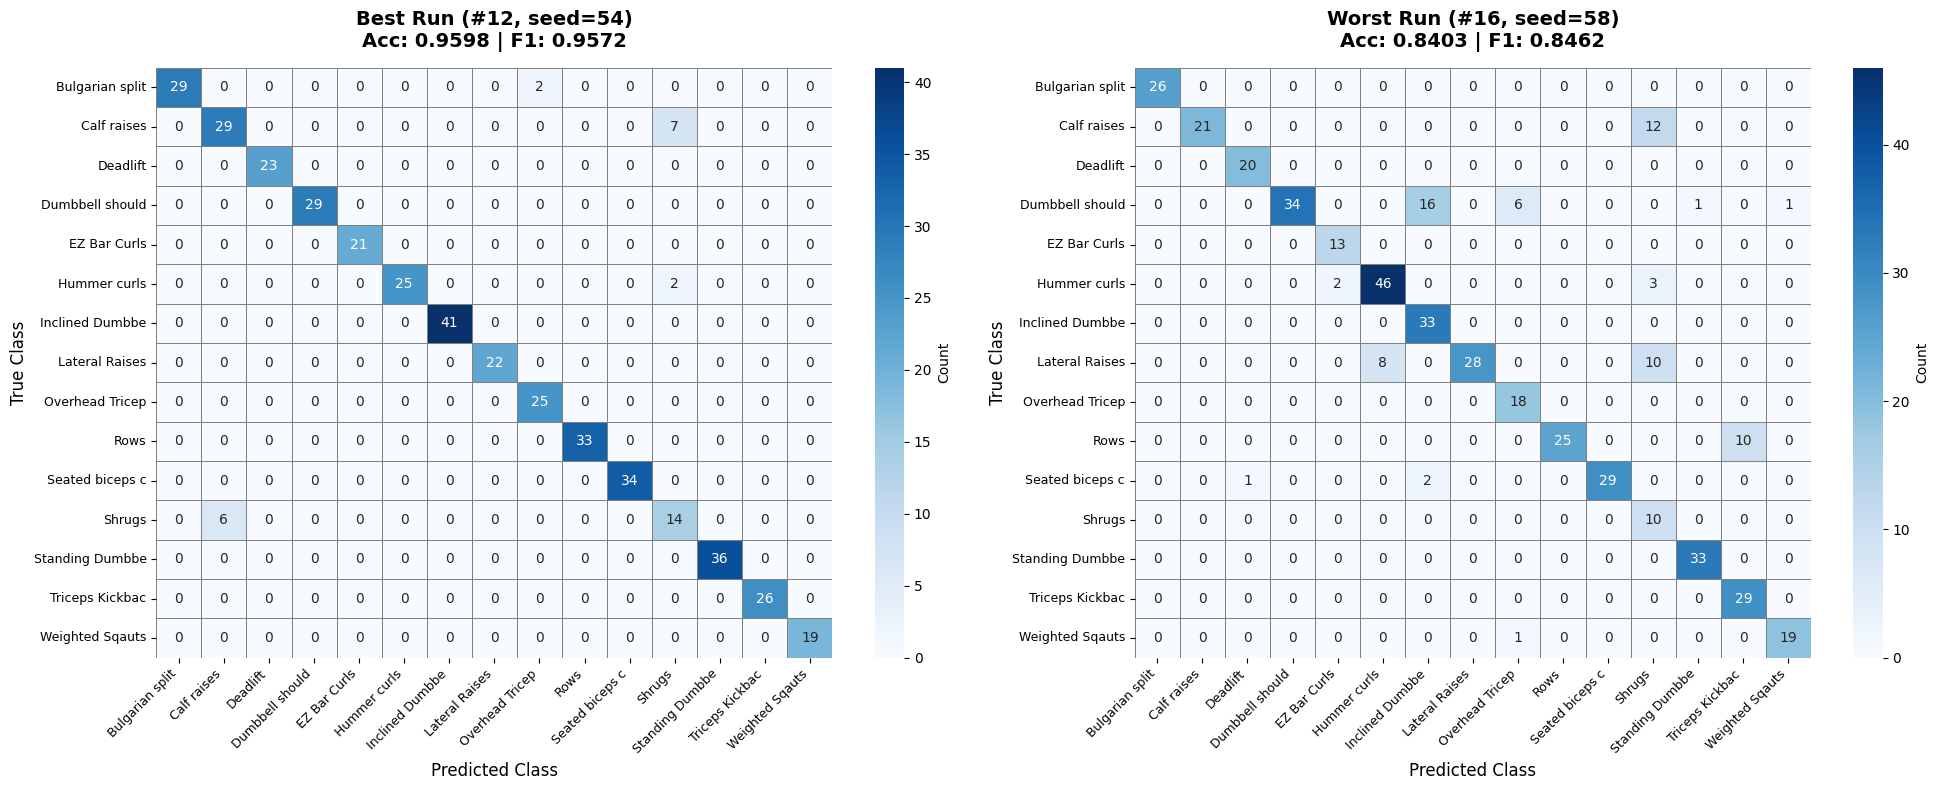


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.9667     1.0000     -0.0333
1        0.8169     0.7778      0.0391
2        1.0000     0.9756      0.0244
3        1.0000     0.7391      0.2609
4        1.0000     0.9286      0.0714
5        0.9615     0.8762      0.0853
6        1.0000     0.7857      0.2143
7        1.0000     0.7568      0.2432
8        0.9615     0.8372      0.1243
9        1.0000     0.8333      0.1667
10       1.0000     0.9508      0.0492
11       0.6512     0.4444      0.2067
12       1.0000     0.9851      0.0149
13       1.0000     0.8529      0.1471
14       1.0000     0.9500      0.0500


In [8]:
# Best vs worst run comparison
label_names = sorted(multi_run_results[0]['label_to_int'].keys())
ordered_labels = sort_labels_by_numeric_prefix(label_names)

print("\n" + "=" * 80)
print(f"CONFIG {SELECTED_CONFIG}: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df = plot_best_worst_comparison(multi_run_results, ordered_labels)

### Best vs Worst Run Comparison

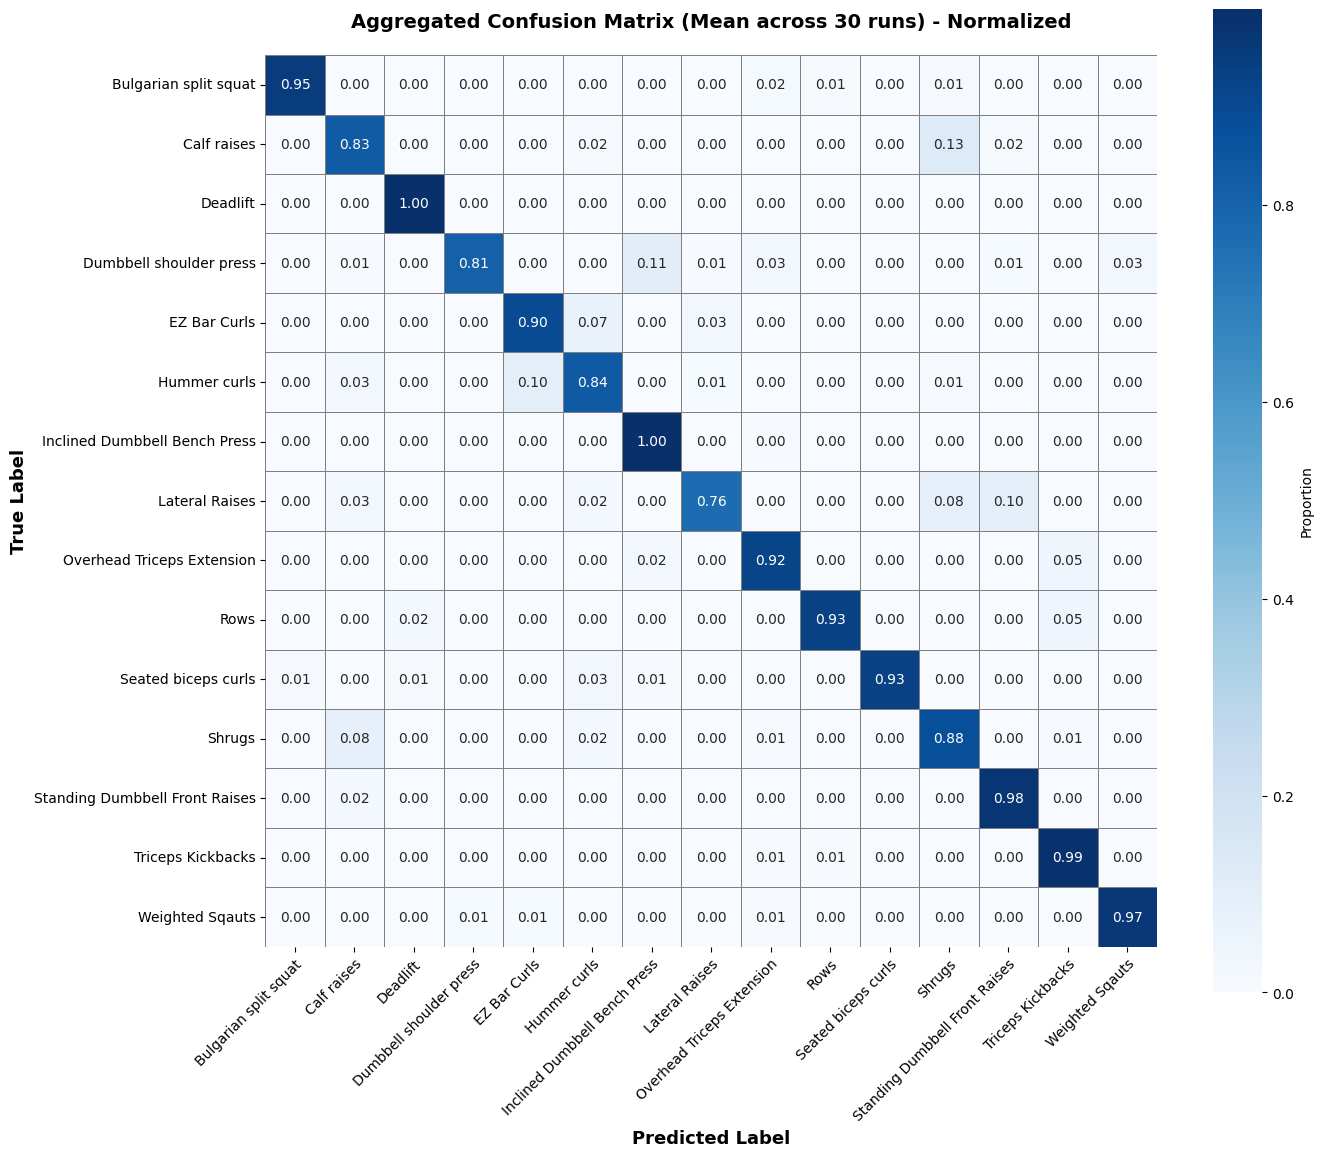

array([[2.24000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.66666667e-02, 0.00000000e+00,
        4.00000000e-01, 3.33333333e-01, 0.00000000e+00, 3.33333333e-01,
        0.00000000e+00, 3.33333333e-02, 0.00000000e+00],
       [0.00000000e+00, 2.78666667e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.33333333e-01, 0.00000000e+00, 1.00000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.43333333e+00,
        5.66666667e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.15333333e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.33333333e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33333333e-02, 2.00000000e-01, 0.00000000e+00, 3.15666667e+01,
        0.00000000e+00, 0.00000000e+00, 4.16666667e+00, 2.00000000e-01,
        1.10000000e+00, 0.00000000e+0

In [9]:
plot_aggregated_confusion_matrix(
    multi_run_results,
    label_names=ordered_labels,
    desired_class_order=ordered_labels,
    normalize=True
)

In [11]:
# Get best run for detailed analysis
best_run = max(multi_run_results, key=lambda x: x['test_metrics']['macro_f1'])

print(f"🏆 Best Run Performance (Config {SELECTED_CONFIG} - {SELECTED_VIEW}):")
print(f"   Accuracy: {best_run['test_metrics']['accuracy']:.4f}")
print(f"   Macro F1: {best_run['test_metrics']['macro_f1']:.4f}")

🏆 Best Run Performance (Config C - front):
   Accuracy: 0.9190
   Macro F1: 0.9238


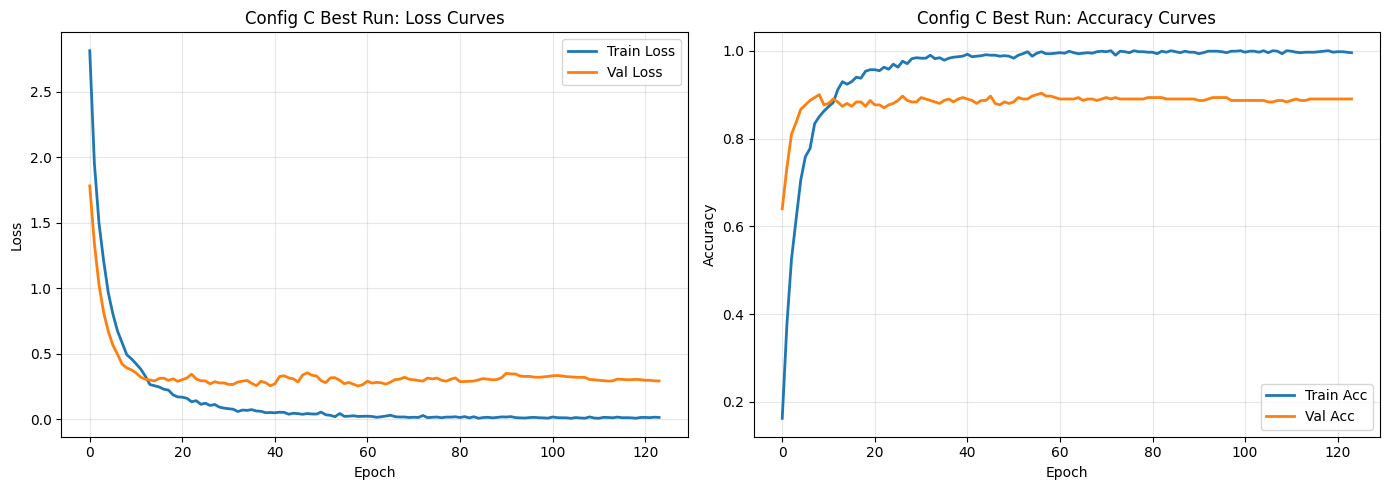

In [12]:
# Plot training history for best run
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(best_run['history']['loss'], label='Train Loss', linewidth=2)
axes[0].plot(best_run['history']['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Config {SELECTED_CONFIG} Best Run: Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(best_run['history']['accuracy'], label='Train Acc', linewidth=2)
axes[1].plot(best_run['history']['val_accuracy'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Config {SELECTED_CONFIG} Best Run: Accuracy Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Per-Class F1 Scores

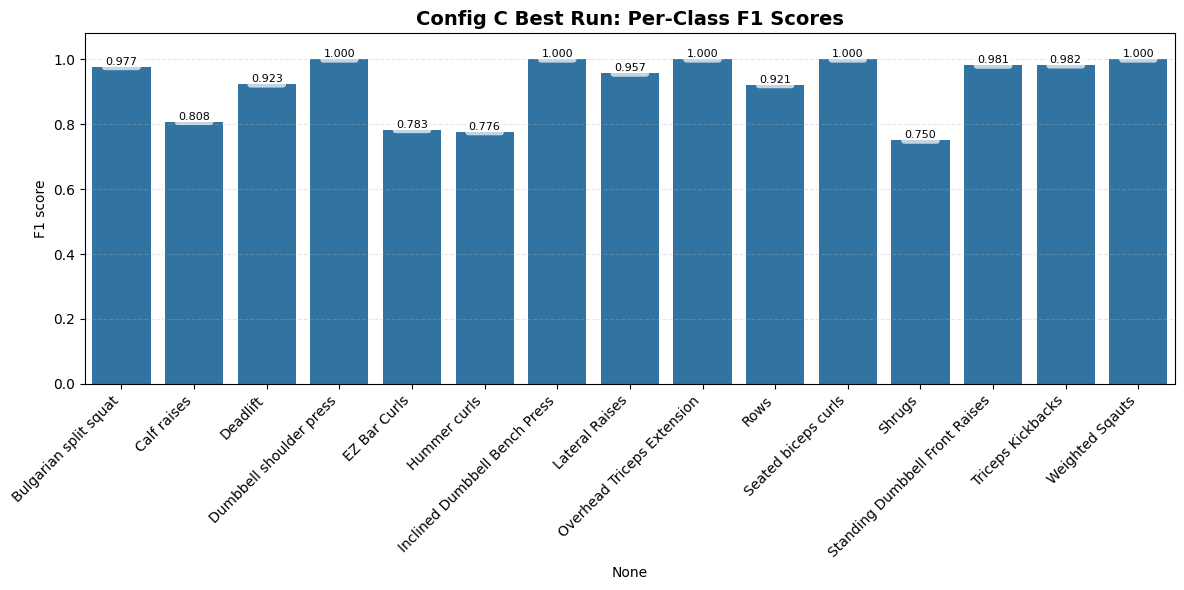

In [13]:
# Per-class F1 scores for best run
idx_to_label = {int(k): v for k, v in best_run['int_to_label'].items()}

fig, ax = plt.subplots(figsize=(12, 6))
plot_per_class_f1_scores(
    best_run['test_metrics']['per_class_f1'],
    idx_to_label,
    desired_class_order=ordered_labels,
    ax=ax
)
ax.set_title(f'Config {SELECTED_CONFIG} Best Run: Per-Class F1 Scores', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

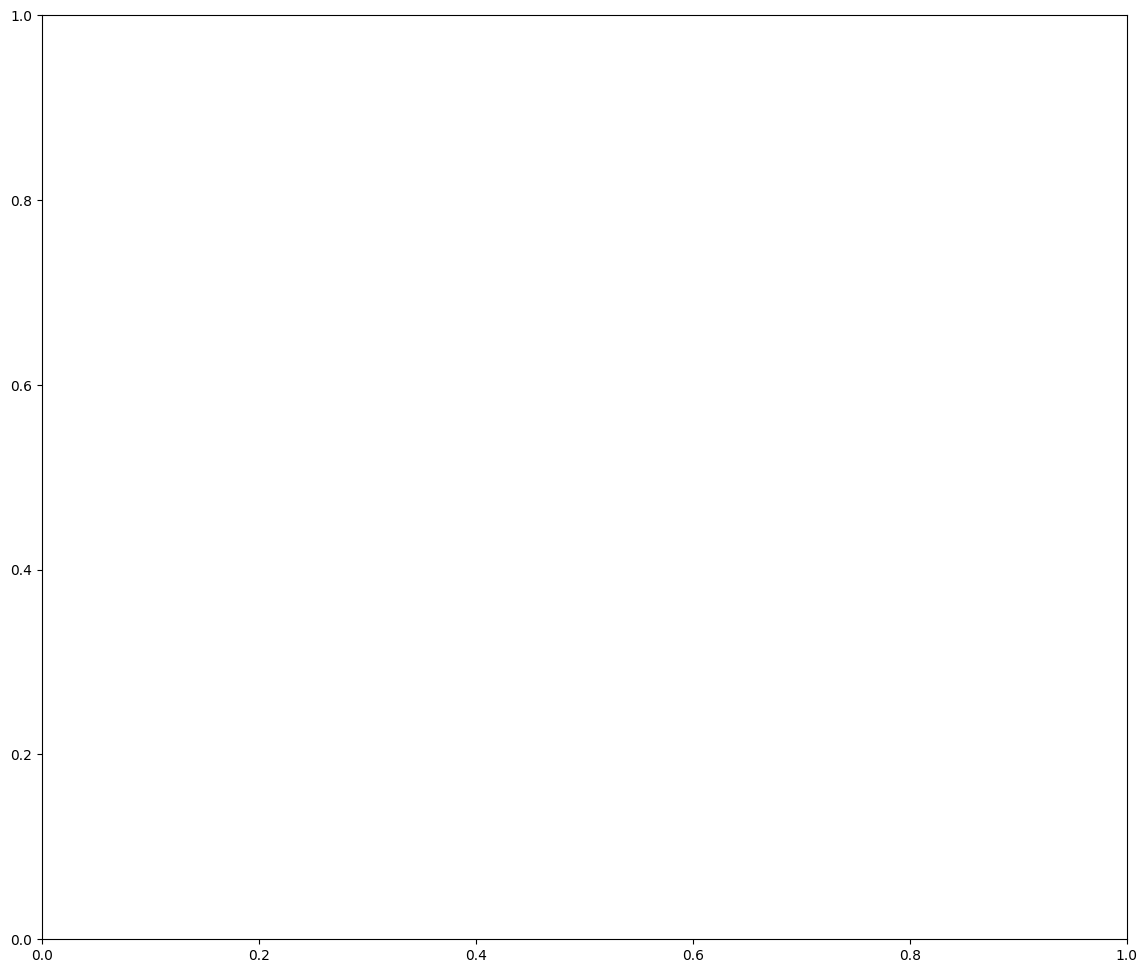

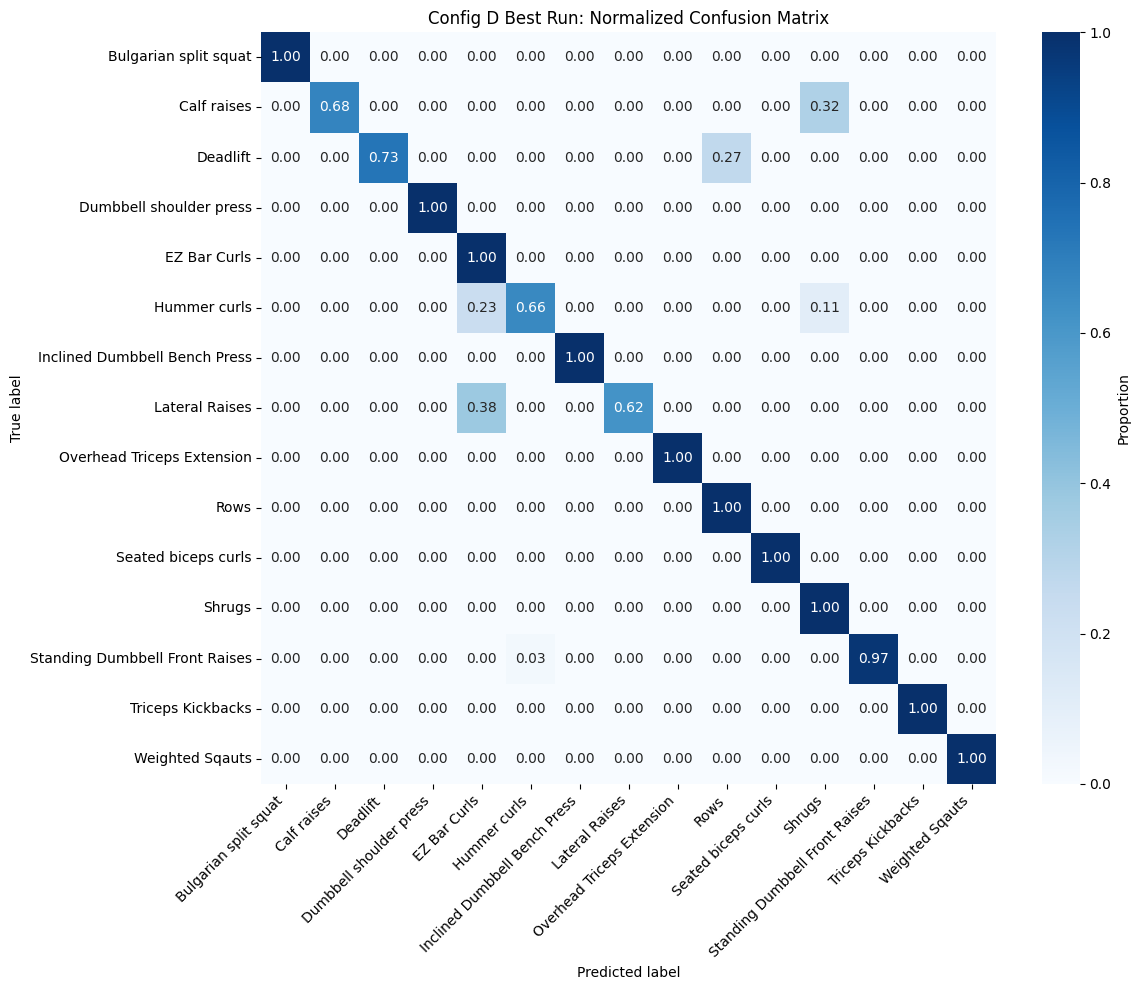

<Figure size 640x480 with 0 Axes>

In [22]:
# Confusion matrix for best run
conf_matrix = np.array(best_run['test_metrics']['confusion_matrix'])

fig, ax = plt.subplots(figsize=(14, 12))
plot_confusion_matrix_from_metrics(
    conf_matrix,
    current_class_order=label_names,
    desired_class_order=ordered_labels,
    normalize=True,
    title=f'Config {SELECTED_CONFIG} Best Run: Normalized Confusion Matrix'
)
plt.tight_layout()
plt.show()

# Final summary

In [14]:
print("=" * 80)
print(f"FINAL SUMMARY: CONFIG {SELECTED_CONFIG} ({config_info['name']}) - {SELECTED_VIEW.upper()} VIEW")
print("=" * 80)
print(f"\nConfiguration Details:")
print(f"  Feature type: {config_info['feature_type']}")
print(f"  Number of features: {config_info['num_features']}")
print(f"  Description: {config_info['description']}")

print(f"\nResults (30 runs):")
print(f"  Test Accuracy: {aggregated_stats['test_accuracy']['mean']:.4f} ± {aggregated_stats['test_accuracy']['std']:.4f}")
print(f"  Test Macro F1: {aggregated_stats['test_macro_f1']['mean']:.4f} ± {aggregated_stats['test_macro_f1']['std']:.4f}")
print(f"  Accuracy Range: [{aggregated_stats['test_accuracy']['min']:.4f}, {aggregated_stats['test_accuracy']['max']:.4f}]")
print(f"  F1 Range: [{aggregated_stats['test_macro_f1']['min']:.4f}, {aggregated_stats['test_macro_f1']['max']:.4f}]")

print(f"\nBest Run:")
print(f"  Accuracy: {best_run['test_metrics']['accuracy']:.4f}")
print(f"  Macro F1: {best_run['test_metrics']['macro_f1']:.4f}")
print("=" * 80)

FINAL SUMMARY: CONFIG C (Base + Specialized) - FRONT VIEW

Configuration Details:
  Feature type: base_specialized
  Number of features: 33
  Description: 19 base + 14 specialized discrimination features

Results (30 runs):
  Test Accuracy: 0.8542 ± 0.0320
  Test Macro F1: 0.8455 ± 0.0372
  Accuracy Range: [0.7596, 0.9190]
  F1 Range: [0.7270, 0.9238]

Best Run:
  Accuracy: 0.9190
  Macro F1: 0.9238


---

## (Optional) Load & Compare Multiple Configurations

Run this section after running multiple configurations to compare their results.

### Side-View Specialized Features (Config B - Side)

The side-view specialized features experiment includes **18 additional features** designed to address confusion patterns specific to the side-view camera angle:

**Feature Groups:**
1. **Vertical Displacement (4 features)**: Targets Shrugs vs Calf Raises
   - `shoulder_elevation_y`, `heel_ground_clearance`, `shoulder_hip_y_ratio`, `ear_shoulder_compression`

2. **Overhead Arm Position (4 features)**: Targets Overhead Triceps Extension
   - `elbow_above_shoulder`, `wrist_above_elbow`, `upper_arm_vertical_angle_side`, `forearm_vertical_angle_side`

3. **Sagittal Arm Trajectory (4 features)**: Targets Curl variants and Pressing movements
   - `wrist_forward_of_shoulder`, `elbow_forward_of_hip`, `arm_reach_forward`, `elbow_tuck_side`

4. **Hip Hinge Profile (4 features)**: Targets Deadlift/Rows/Kickbacks
   - `torso_angle_from_vertical`, `hip_behind_ankle`, `shoulder_forward_of_hip`, `knee_hip_alignment_z`

5. **Postural Stability (2 features)**: General body position context
   - `stance_width_normalized`, `center_of_mass_y`

**Total Features**: 19 base + 18 specialized = **37 features** × 50 timesteps = 1850 input dimensions

**Expected Results**: These features are designed to improve F1 scores for previously underperforming exercises (Shrugs: baseline 0.59, Overhead Triceps Extension: baseline 0.65)

In [ ]:
# Load results from saved multi-run folders (after running multiple configs)
import json
from pathlib import Path

def load_multi_run_stats(results_dir: str) -> dict:
    """Load aggregated stats from a multi-run results folder."""
    stats_path = Path(results_dir) / 'aggregated_stats.json'
    if stats_path.exists():
        with open(stats_path, 'r') as f:
            return json.load(f)
    return None

# Define result directories for each config and view combination
# Update the multi_run folder numbers to match your actual results
result_dirs_front = {
    'A': PROJECT_ROOT / 'output/exer_recog/exp_06_pose_mlp_temporal/front/multi_run_001',
    'B': PROJECT_ROOT / 'output/exer_recog/exp_06_ablation_specialized/front/multi_run_001',
}

result_dirs_side = {
    'A': PROJECT_ROOT / 'output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_003',
    'B': PROJECT_ROOT / 'output/exer_recog/exp_06_ablation_specialized/side/multi_run_001',
}

# Select appropriate result directories based on current view
result_dirs = result_dirs_front if SELECTED_VIEW == 'front' else result_dirs_side

# Load stats directly from specified folders
all_stats = {}
for config_name, multi_run_folder in result_dirs.items():
    if multi_run_folder.exists():
        stats = load_multi_run_stats(str(multi_run_folder))
        if stats:
            all_stats[config_name] = stats
            print(f"✅ Loaded Config {config_name} ({SELECTED_VIEW}) from {multi_run_folder.name}")
        else:
            print(f"⚠️  Config {config_name}: No aggregated_stats.json found in {multi_run_folder}")
    else:
        print(f"⚠️  Config {config_name}: Directory not found - {multi_run_folder}")

print(f"\nLoaded {len(all_stats)} configurations for comparison ({SELECTED_VIEW} view)")

✅ Loaded Config A from multi_run_003
✅ Loaded Config B from multi_run_007

Loaded 2 configurations for comparison


In [ ]:
# Compare all loaded configurations
if len(all_stats) >= 2:
    print("=" * 80)
    print(f"CONFIGURATION COMPARISON - {SELECTED_VIEW.upper()} VIEW")
    print("=" * 80)
    
    comparison_data = []
    for config_name, stats in sorted(all_stats.items()):
        config_detail = CONFIG_MAP.get(config_name, {'name': 'Unknown', 'num_features': '?'})
        comparison_data.append({
            'Config': f"{config_name} ({config_detail['name']})",
            'Features': config_detail['num_features'],
            'Accuracy': f"{stats['test_accuracy']['mean']:.4f} ± {stats['test_accuracy']['std']:.4f}",
            'Macro F1': f"{stats['test_macro_f1']['mean']:.4f} ± {stats['test_macro_f1']['std']:.4f}",
            'Acc Range': f"[{stats['test_accuracy']['min']:.4f}, {stats['test_accuracy']['max']:.4f}]",
            'F1 Range': f"[{stats['test_macro_f1']['min']:.4f}, {stats['test_macro_f1']['max']:.4f}]"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    print(comparison_df.to_string(index=False))
    
    # Calculate improvement from Config A to Config B
    if 'A' in all_stats and 'B' in all_stats:
        acc_improvement = all_stats['B']['test_accuracy']['mean'] - all_stats['A']['test_accuracy']['mean']
        f1_improvement = all_stats['B']['test_macro_f1']['mean'] - all_stats['A']['test_macro_f1']['mean']
        print(f"\n📈 Improvement from Baseline (A) to Specialized (B):")
        print(f"   Accuracy: {acc_improvement:+.4f} ({acc_improvement*100:+.2f}%)")
        print(f"   Macro F1: {f1_improvement:+.4f} ({f1_improvement*100:+.2f}%)")
    
    # Find best config
    best_config = max(all_stats.keys(), key=lambda x: all_stats[x]['test_macro_f1']['mean'])
    best_f1 = all_stats[best_config]['test_macro_f1']['mean']
    print(f"\n🏆 Best Configuration: {best_config} ({CONFIG_MAP[best_config]['name']}) with Macro F1 = {best_f1:.4f}")
    print("=" * 80)
else:
    print("⚠️  Need at least 2 configurations to compare. Run more configs first.")

CONFIGURATION COMPARISON


                Config  Features        Accuracy        Macro F1        Acc Range         F1 Range
          A (Baseline)        19 0.8926 ± 0.0264 0.8774 ± 0.0288 [0.8378, 0.9490] [0.8116, 0.9324]
B (Base + Specialized)        37 0.8374 ± 0.0641 0.8343 ± 0.0653 [0.6095, 0.9144] [0.6013, 0.9155]

🏆 Best Configuration: A (Baseline) with Macro F1 = 0.8774


---

## (Optional) Load & Plot Aggregated Confusion Matrix from Saved Results

Load a saved multi-run result and plot its aggregated confusion matrix across all 30 runs.

✅ Loaded 30 runs from multi_run_010


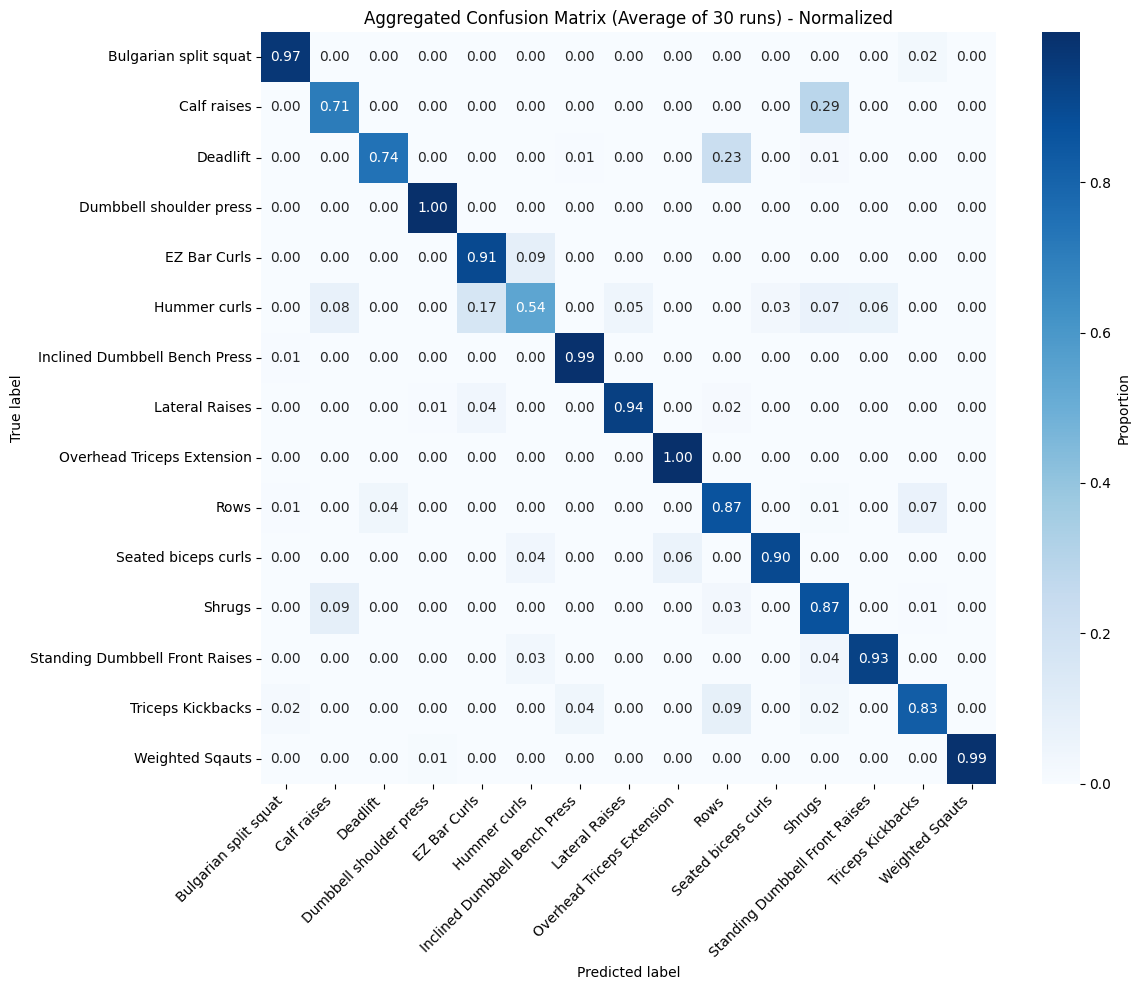

<Figure size 640x480 with 0 Axes>


📊 Confusion Matrix Statistics:
  Total runs averaged: 30
  Classes: 15


In [3]:
# Load all runs from a saved multi-run folder and compute aggregated confusion matrix
import json
from pathlib import Path

# Specify the multi-run folder to load (update path as needed)
MULTI_RUN_PATH = PROJECT_ROOT / 'output/exer_recog/exp_06_ablation_specialized/front/multi_run_010'

# Load all runs data
all_runs_path = MULTI_RUN_PATH / 'all_runs.json'
if all_runs_path.exists():
    with open(all_runs_path, 'r') as f:
        loaded_runs = json.load(f)
    
    print(f"✅ Loaded {len(loaded_runs)} runs from {MULTI_RUN_PATH.name}")
    
    # Extract label names and create ordered list
    first_run = loaded_runs[0]
    label_names = sorted(first_run['label_to_int'].keys())
    ordered_labels = sort_labels_by_numeric_prefix(label_names)
    num_classes = len(label_names)
    
    # Aggregate confusion matrices
    aggregated_cm = np.zeros((num_classes, num_classes), dtype=np.float32)
    for run in loaded_runs:
        cm = np.array(run['test_metrics']['confusion_matrix'])
        aggregated_cm += cm
    
    # Average across all runs
    aggregated_cm /= len(loaded_runs)
    
    # Plot aggregated confusion matrix
    plot_confusion_matrix_from_metrics(
        aggregated_cm,
        current_class_order=label_names,
        desired_class_order=ordered_labels,
        normalize=True,
        title=f'Aggregated Confusion Matrix (Average of {len(loaded_runs)} runs) - Normalized'
    )
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Confusion Matrix Statistics:")
    print(f"  Total runs averaged: {len(loaded_runs)}")
    print(f"  Classes: {num_classes}")
    
else:
    print(f"⚠️  File not found: {all_runs_path}")
    print(f"   Make sure to run training first or update MULTI_RUN_PATH")